## Extracting results for the contamination detection of actual models
This notebook extracts the results from the output of ConStat, section 4.3-4.5. We also extract the GSM8k table in the appendix associated with section 4.2 and creat the plot for Fig 2.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

### Setup

In [2]:
base_path = '../tables'

In [3]:
ref_models = [
    "microsoft/phi-2",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-7b-hf",
    "meta-llama/Llama-2-13b-chat-hf",
    "meta-llama/Llama-2-13b-hf",
    "meta-llama/Llama-3-70b-chat-hf",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Llama-2-70b-chat-hf",
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "mistralai/Mistral-7B-Instruct-v0.1",
    "tiiuae/falcon-7b-instruct",
    "tiiuae/falcon-7b",
    "google/gemma-1.1-2b-it",
    "google/gemma-1.1-7b-it",
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "microsoft/Phi-3-mini-4k-instruct",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    "allenai/OLMo-7B-Instruct",
    "mistralai/Mixtral-8x7B-Instruct-v0.1"
    "mistralai/Mistral-7B-v0.1"
]

### Getting all data from the results

In [4]:
def get_all_data():
    data = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.csv'):
                try:
                    pandas_data = pd.read_csv(os.path.join(root, file))
                    benchmark_name, type_ = file.split('_')
                    pandas_data['benchmark'] = benchmark_name
                    pandas_data['type'] = type_.split('.')[0]
                    pandas_data['is_test_model'] = pandas_data['model'].apply(lambda x: 'contamination-model' in x)
                    pandas_data['is_ref_model'] = pandas_data['model'].apply(lambda x: x in ref_models)
                    data.append(pandas_data)
                except Exception as e:
                    print(e, file)
    return pd.concat(data)

data = get_all_data()
# remove duplicates
data = data.drop_duplicates(subset=['model', 'benchmark', 'type'], keep='last')

In [5]:
data['is_ref_model'] = data['model'].apply(lambda x: x in ref_models)
data['is_test_model'] = data['model'].apply(lambda x: 'contamination-models-' in x)
ref_data = data[data['is_ref_model']]

### Table 2
This section extract the data for table 2 and tables in the appendix associated with this table. Output format goes straight into the LaTeX format.

In [6]:
def HB_correction(input_data, alpha=0.05):
    sorted_p_values = np.array(input_data.sort_values('p_value')['p_value'])
    n = len(sorted_p_values)
    weights = np.array([i / n for i in range(1, n + 1)])
    significant = sorted_p_values <= weights * alpha
    # get the highest index for which the p-value is significant
    k = len(significant) - np.argmax(significant[::-1]) - 1
    if np.count_nonzero(significant) == 0:
        return 0
    return sorted_p_values[k]

In [7]:
significant_df = []
for benchmark in ref_data['benchmark'].unique():
    for type_ in ref_data['type'].unique():
        subset = ref_data[np.logical_and(ref_data['benchmark'] == benchmark, ref_data['type'] == type_)]
        if len(subset) > 0:
            significant_p = HB_correction(subset)
            significant_df.append(subset[subset['p_value'] <= significant_p])
significant_df = pd.concat(significant_df)

In [8]:
# multiply all numbers by 100
significant_df['score_model'] = significant_df['score_model'] * 100
significant_df['delta'] = significant_df['delta'] * 100
significant_df['min_delta_095'] = significant_df['min_delta_095'] * 100
significant_df['p_value'] = significant_df['p_value'] * 100
print(significant_df[['model', 'benchmark', 'type', 'score_model', 'p_value', 'delta', 'min_delta_095']].to_latex(index=False))

\begin{tabular}{lllrrrr}
\toprule
model & benchmark & type & score_model & p_value & delta & min_delta_095 \\
\midrule
mistralai/Mistral-7B-v0.1 & gsm8k & synthetic & 39.044731 & 0.150000 & 8.245073 & 4.479598 \\
microsoft/phi-2 & gsm8k & reference & 58.908264 & 0.000000 & 36.418186 & 26.464750 \\
microsoft/Phi-3-mini-4k-instruct & gsm8k & reference & 76.648976 & 0.290000 & 16.298102 & 6.328980 \\
allenai/OLMo-7B-Instruct & gsm8k & reference & 11.751327 & 0.000000 & 8.863050 & 4.989178 \\
meta-llama/Llama-2-70b-chat-hf & hellaswag & synthetic & 85.550000 & 0.410000 & 3.368447 & 1.287811 \\
mistralai/Mistral-7B-v0.1 & hellaswag & synthetic & 83.650000 & 0.240000 & 3.135526 & 1.271238 \\
mistralai/Mistral-7B-Instruct-v0.2 & hellaswag & reference & 84.550000 & 0.180000 & 3.524014 & 1.562859 \\
meta-llama/Meta-Llama-3-70B & arc & synthetic & 69.027304 & 0.030000 & 6.609663 & 3.212481 \\
mistralai/Mistral-7B-Instruct-v0.2 & arc & reference & 62.457338 & 0.040000 & 10.619953 & 5.953197 \\
\b

In [9]:
models = [
    'meta-llama/Llama-2-70b-chat-hf',
    "mistralai/Mistral-7B-v0.1",
    'meta-llama/Meta-Llama-3-70B'
]
significant_df = data[data['type'] == 'synthetic'][data[data['type'] == 'synthetic']['model'].apply(lambda x: x in models)]
# sort by model
significant_df = significant_df.sort_values(['model', 'benchmark'])
significant_df['score_model'] = significant_df['score_model'] * 100
significant_df['delta'] = significant_df['delta'] * 100
significant_df['min_delta_095'] = significant_df['min_delta_095'] * 100
significant_df['p_value'] = significant_df['p_value'] * 100
print(significant_df[['model', 'benchmark', 'type', 'score_model', 'p_value', 'delta', 'min_delta_095']].to_latex(index=False))

\begin{tabular}{lllrrrr}
\toprule
model & benchmark & type & score_model & p_value & delta & min_delta_095 \\
\midrule
meta-llama/Llama-2-70b-chat-hf & arc & synthetic & 61.860068 & 14.680000 & 1.961763 & -1.014571 \\
meta-llama/Llama-2-70b-chat-hf & gsm8k & synthetic & 55.799848 & 58.600000 & -0.408819 & -4.420310 \\
meta-llama/Llama-2-70b-chat-hf & hellaswag & synthetic & 85.550000 & 0.410000 & 3.368447 & 1.287811 \\
meta-llama/Llama-2-70b-chat-hf & mmlu & synthetic & 56.852300 & 32.910000 & 0.712501 & -2.097160 \\
meta-llama/Meta-Llama-3-70B & arc & synthetic & 69.027304 & 0.030000 & 6.609663 & 3.212481 \\
meta-llama/Meta-Llama-3-70B & gsm8k & synthetic & 81.576952 & 15.450000 & 2.052300 & -1.486972 \\
meta-llama/Meta-Llama-3-70B & hellaswag & synthetic & 86.450000 & 1.010000 & 2.858603 & 0.897152 \\
meta-llama/Meta-Llama-3-70B & mmlu & synthetic & 76.464891 & 5.760000 & 3.346078 & -0.212983 \\
mistralai/Mistral-7B-v0.1 & arc & synthetic & 58.959044 & 7.910000 & 2.210294 & -0.395809

### GSM8k Table Appenidx
We extract the table for the controlled models for gsm8k

In [10]:
controlled_data = data[data['is_test_model']]

In [11]:
data_here = controlled_data[np.logical_and(np.logical_and(controlled_data['benchmark'] == 'gsm8k', controlled_data['type'] != 'reference'), controlled_data['type'] != 'normal')][['model', 'type', 'score_model', 'p_value', 'no_cont', 'delta', 'min_delta_095']]
data_here['model'] = data_here['model'].apply(lambda x: x.split('/')[1].replace('contamination-models-gsm8k-', ''))

In [12]:
# join synthetic rows with the rephrase rows in data_here
data_here_rephrase = data_here[data_here['type'] == 'rephrase']
data_here_synthetic = data_here[data_here['type'] == 'synthetic']
# join based on model name
data_here_merged = data_here_rephrase.merge(data_here_synthetic, on='model', suffixes=('_rephrase', '_synthetic'))

In [13]:
data_here_merged['delta_diff'] = data_here_merged['delta_synthetic'] / data_here_merged['delta_rephrase']
data_here_merged[data_here_merged['p_value_rephrase'] < 0.05]['delta_diff'].mean()

2.286787600526083

In [14]:
data_here_merged['setting'] = 1 # just some placeholder
data_here_merged['score_model_rephrase'] = data_here_merged['score_model_rephrase'] * 100
data_here_merged['delta_rephrase'] = data_here_merged['delta_rephrase'] * 100
data_here_merged['p_value_rephrase'] = data_here_merged['p_value_rephrase'] * 100
data_here_merged['delta_synthetic'] = data_here_merged['delta_synthetic'] * 100
data_here_merged['p_value_synthetic'] = data_here_merged['p_value_synthetic'] * 100
data_here_merged['actual_delta'] = data_here_merged['score_model_rephrase'] - data_here_merged['no_cont_rephrase'] * 100
print(data_here_merged[['model', 'setting', 'score_model_rephrase', 'actual_delta', 'p_value_rephrase', 'delta_rephrase', 'p_value_synthetic', 'delta_synthetic']].to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
model & setting & score_model_rephrase & actual_delta & p_value_rephrase & delta_rephrase & p_value_synthetic & delta_synthetic \\
\midrule
meta-llama-Llama-2-7b-chat-hf-default & 1 & 92.109256 & 79.381984 & 0.000000 & 40.350861 & 0.000000 & 82.774420 \\
meta-llama-Llama-2-7b-chat-hf-rephrase & 1 & 64.643399 & 50.400975 & 99.140000 & -6.797609 & 0.000000 & 55.718864 \\
meta-llama-Llama-2-7b-chat-hf-lr_1e-4 & 1 & 73.292868 & 69.959535 & 0.000000 & 43.604272 & 0.000000 & 72.175238 \\
meta-llama-Llama-2-7b-chat-hf-lr_1e-5 & 1 & 38.846737 & 15.513404 & 0.000000 & 12.617099 & 0.000000 & 19.084580 \\
meta-llama-Llama-2-7b-chat-hf-repeat_1 & 1 & 25.189681 & 7.916954 & 0.940000 & 5.424925 & 0.000000 & 11.943160 \\
meta-llama-Llama-2-7b-chat-hf-default_other & 1 & 89.529590 & 76.347772 & 0.000000 & 38.075745 & 0.000000 & 82.803218 \\
meta-llama-Llama-2-7b-chat-hf-default_no & 1 & 80.273141 & 65.727687 & 0.000000 & 37.363443 & 0.000000 & 71.743418 \\
meta-llama

### Creation of the plot in Fig 2

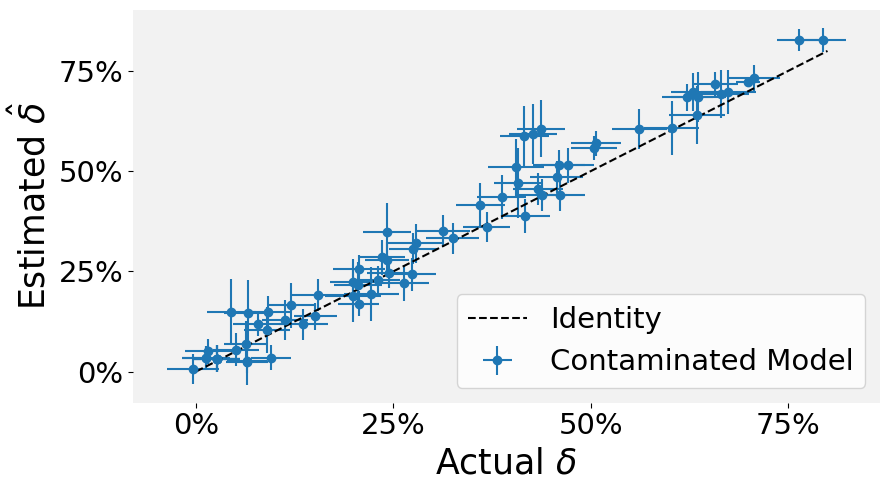

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

controlled_data = controlled_data[controlled_data['type'] == 'synthetic']
controlled_data.to_csv('controlled_data.csv', index=False)
delta = controlled_data['score_model'] - controlled_data['estimated_contamination']
delta_std = controlled_data['estimated_contamination_std']

actual_delta = controlled_data['score_model'] - controlled_data['no_cont']
actual_delta_std = controlled_data['score_model_ref_std']

ax.errorbar(actual_delta, 
            delta, xerr=1.96 * actual_delta_std, 
            yerr=1.96 * delta_std, fmt='o', label='Contaminated Model')
ax.plot([0, 0.8], [0, 0.8], 'k--', label='Identity')
ax.set_xlabel(r'Actual $\delta$', fontsize=25)
ax.set_ylabel(r'Estimated $\hat{\delta}$', fontsize=25)

# set xticks to 0, 0.2, 0.4, 0.6, 0.8
ax.set_xticks([0, 0.25, 0.5, 0.75])
# set xticklaebls to %
ax.set_xticklabels([f'{int(x*100)}%' for x in ax.get_xticks()])
# set yticks to 0, 0.2, 0.4, 0.6, 0.8
ax.set_yticks([0, 0.25, 0.5, 0.75])
# set yticklaebls to %
ax.set_yticklabels([f'{int(x*100)}%' for x in ax.get_yticks()])

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# set grey background color
ax.tick_params(axis='both', which='major', labelsize=21)
ax.set_facecolor((0.95, 0.95, 0.95))
ax.legend(fontsize=21, loc='lower right')
fig.tight_layout()

### Checking the models above the line
We briefly check the models that appear so much above the line

In [16]:
controlled_data[delta - actual_delta > 0.15]

,Unnamed: 0,score_model,score_model_std,score_model_ref,score_model_ref_std,p_value,estimated_contamination,estimated_contamination_025,estimated_contamination_975,estimated_contamination_std,delta,delta_std,min_delta_095,model,no_cont,no_cont_std,benchmark,type,is_test_model,is_ref_model
47,47,1.0,0.0,0.406406,0.015540,0.0,0.394082,0.336189,0.481476,0.036329,0.605918,0.036329,0.535818,JasperDekoninck/contamination-models-hellaswag...,0.563,0.015685,hellaswag,synthetic,True,False
52,52,1.0,0.0,0.420420,0.015618,0.0,0.407903,0.348428,0.501592,0.038202,0.592097,0.038202,0.517400,JasperDekoninck/contamination-models-hellaswag...,0.573,0.015642,hellaswag,synthetic,True,False
53,53,1.0,0.0,0.425425,0.015642,0.0,0.412653,0.352032,0.507343,0.038631,0.587347,0.038631,0.511571,JasperDekoninck/contamination-models-hellaswag...,0.584,0.015587,hellaswag,synthetic,True,False


### Model Families (4.4)
We extract the significant results for the model families evaluated in 4.4

In [17]:
no_ref_data = data[np.logical_and(np.logical_not(data['is_ref_model']), np.logical_not(data['is_test_model']))]
no_ref_data = no_ref_data[no_ref_data['type'] != 'normal']
care_about = no_ref_data[no_ref_data['p_value'] < 0.01][['model', 'benchmark', 'type', 'score_model', 'p_value', 'delta', 'min_delta_095']]
# multiply all numbers by 100
care_about['score_model'] = care_about['score_model'] * 100
care_about['delta'] = care_about['delta'] * 100
care_about['min_delta_095'] = care_about['min_delta_095'] * 100
care_about['p_value'] = care_about['p_value'] * 100

# sort by model
care_about = care_about.sort_values(['model', 'benchmark', 'type'])
print(care_about.to_latex(index=False))

\begin{tabular}{lllrrrr}
\toprule
model & benchmark & type & score_model & p_value & delta & min_delta_095 \\
\midrule
BarraHome/Mistroll-7B-v2.2 & arc & reference & 72.525597 & 0.000000 & 22.207655 & 17.063830 \\
BarraHome/Mistroll-7B-v2.2 & gsm8k & reference & 74.526156 & 0.000000 & 29.278076 & 17.770339 \\
BarraHome/Mistroll-7B-v2.2 & gsm8k & synthetic & 74.526156 & 0.340000 & 7.342518 & 3.054735 \\
BarraHome/Mistroll-7B-v2.2 & hellaswag & reference & 88.600000 & 0.000000 & 12.954633 & 10.149874 \\
MTSAIR/multi_verse_model & arc & reference & 72.440273 & 0.000000 & 22.118895 & 16.973038 \\
MTSAIR/multi_verse_model & gsm8k & reference & 74.677786 & 0.000000 & 29.838028 & 18.425013 \\
MTSAIR/multi_verse_model & gsm8k & synthetic & 74.677786 & 0.530000 & 7.203836 & 2.648507 \\
MTSAIR/multi_verse_model & hellaswag & reference & 88.550000 & 0.000000 & 12.138477 & 9.559127 \\
Qwen/Qwen1.5-110B-Chat & arc & reference & 69.453925 & 0.120000 & 9.325123 & 4.469376 \\
Qwen/Qwen1.5-14B-Chat & a

### All Output Tables
Finally, we create a script that automatically creates all the tables in the appendix.

In [51]:
data_no_contaminated = data[data['model'].apply(lambda x: 'contamination-models-' not in x)]
data_no_contaminated = data_no_contaminated[data_no_contaminated['type'] != 'normal']
# sort the data by model
data_no_contaminated = data_no_contaminated.sort_values('model')

# multiply all numbers by 100
data_no_contaminated['score_model'] = data_no_contaminated['score_model'] * 100
data_no_contaminated['delta'] = data_no_contaminated['delta'] * 100
data_no_contaminated['min_delta_095'] = data_no_contaminated['min_delta_095'] * 100
data_no_contaminated['p_value'] = data_no_contaminated['p_value'] * 100

In [19]:
model_conversion = {
    'microsoft/phi-2': r'\phimodel[2]',
    'meta-llama/Llama-2-7b-chat-hf': r'\llamainstruct[2][7b]',
    'meta-llama/Llama-2-7b-hf': r'\llama[2][7b]',
    'meta-llama/Llama-2-13b-chat-hf': r'\llamainstruct[2][13b]',
    'meta-llama/Llama-2-13b-hf': r'\llama[2][13b]',
    'meta-llama/Llama-3-70b-chat-hf': r'\llamainstruct[3][70b]',
    'meta-llama/Meta-Llama-3-70B': r'\llama[3][70b]',
    'meta-llama/Llama-2-70b-chat-hf': r'\llamainstruct[2][70b]',
    'mistralai/Mistral-7B-v0.1': r'\mistral[7b][1]',
    'mistral-community/Mistral-7B-v0.2': r'\mistral[7b][2]',
    'mistralai/Mistral-7B-v0.3': r'\mistral[7b][3]',
    'mistralai/Mistral-7B-Instruct-v0.3': r'\mistralinstruct[7b][3]',
    'mistralai/Mistral-7B-Instruct-v0.2': r'\mistralinstruct[7b][2]',
    'mistralai/Mistral-7B-Instruct-v0.1': r'\mistralinstruct[7b][1]',
    'tiiuae/falcon-7b-instruct': r'\falconinstruct[7b]',
    'tiiuae/falcon-7b': r'\falcon[7b]',
    'google/gemma-1.1-2b-it': r'\gemmainstruct[2b]',
    'google/gemma-1.1-7b-it': r'\gemmainstruct[7b]',
    'meta-llama/Meta-Llama-3-8B': r'\llama[3][8b]',
    'meta-llama/Meta-Llama-3-8B-Instruct': r'\llamainstruct[3][8b]',
    'microsoft/Phi-3-mini-4k-instruct': r'\phimodelmini',
    'microsoft/Phi-3-small-8k-instruct': r'\phimodelsmall',
    'microsoft/Phi-3-medium-4k-instruct': r'\phimodelmedium',
    'mistralai/Mixtral-8x22B-Instruct-v0.1': r'\mixtralinstruct[8x22b]',
    'allenai/OLMo-7B-Instruct': r'\olmoinstruct[7b]',
    'mistralai/Mixtral-8x7B-Instruct-v0.1': r'\mixtralinstruct[8x7b]',
    'Qwen/Qwen1.5-14B-Chat': r'\qweninstruct[14b]',
    'Qwen/Qwen1.5-4B-Chat': r'\qweninstruct[4b]',
    'Qwen/Qwen1.5-7B-Chat': r'\qweninstruct[7b]',
    'Qwen/Qwen1.5-72B-Chat': r'\qweninstruct[72b]',
    'Qwen/Qwen1.5-110B-Chat': r'\qweninstruct[110b]',
    'Qwen/Qwen1.5-1.8B-Chat': r'\qweninstruct[1.8b]',
    'yam-peleg/Experiment26-7B': r'\yampeleg',
    'MTSAIR/multi_verse_model': r'\multiverse',
    'BarraHome/Mistroll-7B-v2.2': r'\mistroll',
    'internlm/internlm2-7b': r'\internlm[7b]',
    'internlm/internlm2-math-7b': r'\internlmmath[7b]',
    'internlm/internlm2-math-base-7b': r'\internlmmathbase[7b]',
    'internlm/internlm2-1_8b': r'\internlm[1.8b]',
    'zero-one-ai/Yi-34B': r'\yi[34b]',
    'zero-one-ai/Yi-6B': r'\yi[6b]',
    'stabilityai/stablelm-2-12b-chat': r'\stablelm-\instruct[12b]',
    'stabilityai/stablelm-2-12b': r'\stablelm[12b]',
    'stabilityai/stablelm-zephyr-3b': r'\stablelm-\zephyr[3b]',
    'stabilityai/stablelm-2-1_6b-chat': r'\stablelm-\instruct[1.6b]',
    'stabilityai/stablelm-2-1_6b': r'\stablelm[1.6b]',
    'stabilityai/stablelm-base-alpha-7b-v2': r'\stablelm-\alphamodel[7b]',
}

In [20]:
entire_string = ""
model_done = []
for model in np.unique(data_no_contaminated['model']):
    if model in model_done:
        continue
    models_here = [m for m in model_conversion.keys() if m.split('/')[0] == model.split('/')[0] or ('mistral' in model and 'mistral' in m)]
    if 'Llama' in model:
        number = '-3-' in model
        models_here = [m for m in models_here if (('-3-' in m) == number)]
    if 'stablelm' in model:
        number = 'chat' in model
        models_here = [m for m in models_here if (('chat' in m) == number)]
    if 'Qwen' in model:
        number = '-1.8B' in model or '-4B' in model or '-7B' in model
        models_here = [m for m in models_here if (('-1.8B' in m or '-4B' in m or '-7B' in m) == number)]
    elif 'yam' in model or 'MST' in model or 'Barra' in model:
        models_here = ['yam-peleg/Experiment26-7B', 'MTSAIR/multi_verse_model', 'BarraHome/Mistroll-7B-v2.2']
    elif 'mistral' in model:
        number1 = 'Mixtral' in model
        number2 = 'Instruct' in model
        models_here = [m for m in models_here if (('Mixtral' in m) == number1 and ('Instruct' in m) == number2)]
    model_done += models_here
    if len(models_here) == 0:
        continue
    subset = data_no_contaminated[data_no_contaminated['model'].apply(lambda x: x in models_here)][['model', 'benchmark', 'score_model', 'type', 'p_value', 'delta', 'min_delta_095']]
    subset['p_value'] = subset['p_value'].apply(lambda x: str(x) if x > 0 else r'{$< 10^{-2}$}')
    subset['type'] = subset['type'].apply(lambda x: ['B', 'S', 'Y'][['reference', 'synthetic', 'rephrase'].index(x)])
    subset['benchmark'] = subset['benchmark'].apply(lambda x: {'gsm8k': 'GSM8k', 'arc': 'ARC', 'hellaswag': 'Hellaswag', 'mmlu': 'MMLU'}[x])
    subset['model'] = subset['model'].apply(lambda x: model_conversion[x])
    # sort first by benchmark then by type
    subset = subset.sort_values(['model', 'benchmark', 'type'])
    # set performance of the model for non-benchmark type to empty string
    subset['model'] = subset.apply(lambda x: '' if x['type'] != 'B' or x['benchmark'] != 'ARC' else x['model'], axis=1)
    subset['score_model'] = subset.apply(lambda x: x['score_model'] if x['type'] == 'B' or (x['type'] == 'S' and x['benchmark'] == 'MMLU') else '', axis=1)
    # set the benchmark to empty string for non-benchmark type
    subset['benchmark'] = subset.apply(lambda x: x['benchmark'] if x['type'] == 'B' or (x['type'] == 'S' and x['benchmark'] == 'MMLU') else '', axis=1)
    # rename columns
    subset.columns = ['Model', 'Benchmark', r'{Perf. [\%]}', 'Type', r'{$p$ [\%]}', r'{$\hat{\delta}$ [\%]}', r'{$\hat{\delta}_{0.95}$ [\%]}']
    caption = f"Contamination results for {', '.join([model_conversion[m] for m in models_here])}. B is benchmark-specific, S is sample-specific and Y is syntax-specific contamination. All numbers are reported in percentages."
    label = f"tab:full_results_{model.replace('/', ':')}"
    # column types

    latex_string = subset.to_latex(index=False, caption=caption, label=label)
    latex_string = latex_string.replace(r'\begin{tabular}{lllllrr}', r'\centering\footnotesize\begin{tabular}{lllllrr}')
    latex_string = latex_string.replace('lllllrr', r'llx{2}{2}lx{2}{2}x{2}{2}x{2}{2}')
    entire_string += latex_string + '\n'

# write entire string to file
with open('big_table.txt', 'w') as f:
    f.write(entire_string)   

In [52]:
js_string = ""
# sort data_no_contaminated by model, benchmark and type
# first replace the type rephrase with syntax
data_no_contaminated['type'] = data_no_contaminated['type'].apply(lambda x: 'syntx' if x == 'rephrase' else x)
data_no_contaminated = data_no_contaminated.sort_values(['model', 'benchmark', 'type'])
for row in data_no_contaminated[['model', 'benchmark', 'type', 'score_model', 'p_value', 'delta', 'min_delta_095']].iterrows():
    model, benchmark, type_, score_model, p_value, delta, min_delta_095 = row[1]
    type_ = 'Benchmark' if type_ == 'reference' else 'Sample' if type_ == 'synthetic' else 'Syntax'
    model = model.split("/")[1]
    js_string += f"{{'Model Name': '{model}', 'Benchmark': '{benchmark}', 'Type': '{type_}', 'Performance': {score_model:.2f}, 'p-value': {p_value:.2f}, 'delta': {delta:.2f}, 'delta_095': {min_delta_095:.2f}}},\n"

In [53]:
print(js_string)

{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'arc', 'Type': 'Benchmark', 'Performance': 72.53, 'p-value': 0.00, 'delta': 22.21, 'delta_095': 17.06},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'arc', 'Type': 'Sample', 'Performance': 72.53, 'p-value': 55.90, 'delta': -0.22, 'delta_095': -4.88},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'arc', 'Type': 'Syntax', 'Performance': 72.53, 'p-value': 88.15, 'delta': -3.09, 'delta_095': -7.26},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'gsm8k', 'Type': 'Benchmark', 'Performance': 74.53, 'p-value': 0.00, 'delta': 29.28, 'delta_095': 17.77},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'gsm8k', 'Type': 'Sample', 'Performance': 74.53, 'p-value': 0.34, 'delta': 7.34, 'delta_095': 3.05},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'gsm8k', 'Type': 'Syntax', 'Performance': 74.53, 'p-value': 34.00, 'delta': 0.79, 'delta_095': -2.49},
{'Model Name': 'Mistroll-7B-v2.2', 'Benchmark': 'hellaswag', 'Type': 'Benchmark', 'Performance

In [56]:
js_string = ""
# sort data_no_contaminated by model, benchmark and type
# first replace the type rephrase with syntax
data_no_contaminated['type'] = data_no_contaminated['type'].apply(lambda x: 'syntx' if x == 'rephrase' else x)
data_no_contaminated = data_no_contaminated.sort_values(['model', 'benchmark', 'type'])

for model in np.unique(data_no_contaminated['model']):
    # get all rows for the model
    subset = data_no_contaminated[data_no_contaminated['model'] == model]
    model_name = model.split("/")[1]
    # add to the string all p-values for the model
    js_string += f"{{'Model Name': '{model_name}', "
    for row in subset[['model', 'benchmark', 'type', 'score_model', 'p_value', 'delta', 'min_delta_095']].iterrows():
        _, benchmark, type_, score_model, p_value, delta, min_delta_095 = row[1]
        type_ = 'Benchmark' if type_ == 'reference' else 'Sample' if type_ == 'synthetic' else 'Syntax'
        js_string += f"'{benchmark}_{type_}': {p_value:.2f}, "
    js_string += "},\n"

print(js_string)

{'Model Name': 'Mistroll-7B-v2.2', 'arc_Benchmark': 0.00, 'arc_Sample': 55.90, 'arc_Syntax': 88.15, 'gsm8k_Benchmark': 0.00, 'gsm8k_Sample': 0.34, 'gsm8k_Syntax': 34.00, 'hellaswag_Benchmark': 0.00, 'hellaswag_Sample': 96.48, 'hellaswag_Syntax': 12.88, 'mmlu_Sample': 35.65, 'mmlu_Syntax': 85.66, },
{'Model Name': 'multi_verse_model', 'arc_Benchmark': 0.00, 'arc_Sample': 51.07, 'arc_Syntax': 87.29, 'gsm8k_Benchmark': 0.00, 'gsm8k_Sample': 0.53, 'gsm8k_Syntax': 47.26, 'hellaswag_Benchmark': 0.00, 'hellaswag_Sample': 96.40, 'hellaswag_Syntax': 10.12, 'mmlu_Sample': 33.99, 'mmlu_Syntax': 81.48, },
{'Model Name': 'Qwen1.5-1.8B-Chat', 'arc_Benchmark': 97.39, 'arc_Sample': 65.23, 'arc_Syntax': 75.55, 'gsm8k_Benchmark': 16.59, 'gsm8k_Sample': 26.48, 'gsm8k_Syntax': 5.62, 'hellaswag_Benchmark': 100.00, 'hellaswag_Sample': 99.73, 'hellaswag_Syntax': 82.43, 'mmlu_Sample': 34.60, 'mmlu_Syntax': 32.23, },
{'Model Name': 'Qwen1.5-110B-Chat', 'arc_Benchmark': 0.12, 'arc_Sample': 54.00, 'arc_Syntax': 